In [200]:
torch.cuda.empty_cache()

In [201]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook
import re
import requests
import numpy as np
import time
import copy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import load_iris
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [202]:
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'
train_image = train_dir + '/images'
train_df = pd.read_csv(train_dir + '/train.csv')
test_df = pd.read_csv(test_dir + '/info.csv')
path_df = train_dir + '/train.csv'

In [203]:
def age_to_classification(age):
    age = int(age)
    if age < 30 :
        trans_age = 0
    elif 30 <= age < 60:
        trans_age = 1
    elif age >= 60:
        trans_age = 2
    return trans_age

class CustomDataset(Dataset):
    def __init__(self, transform, path, image_path, train):
        self.path = path
        self.transform = transform
        self.image_path = image_path
        self.df = self.make_dataset()
        self.df['score'] = self.df['value'] * 6 + self.df['gender'] * 3 + self.df['age'] 
        self.column = self.df.columns
        self.labels = self.df.iloc[:,-1] ## 첫번째 칼럼이 label
        self.index = self.df.index.values
        self.train = train
    def __len__(self):
        return len(self.df)    
    

    def __getitem__(self, idx):
        image_path = '/'.join([train_image, self.df['path'][idx], self.df['file'][idx]])
        archor_image = Image.open(image_path)
        self.label = self.df['score'][idx]
        if self.train == True:
            anchor_label = self.labels[idx]
            positive_list = self.index[self.index != idx][self.labels[self.index!=idx]==anchor_label]
            
            positive_idx = random.choice(positive_list) 
            ## 해당 anchor가 아닌 것들중에서 Label 다른 것들의 index를 가지고 옮
            negative_list = self.index[self.index != idx][self.labels[self.index!=idx]!=anchor_label]
            
            negative_idx = random.choice(negative_list)

            positive_path = '/'.join([train_image,
                                    self.df['path'][positive_idx],
                                    self.df['file'][positive_idx]])
            negative_path = '/'.join([train_image,
                                    self.df['path'][negative_idx],
                                    self.df['file'][negative_idx]])

            positive_image = Image.open(positive_path)
            negative_image = Image.open(negative_path)

            self.label = [self.labels[idx], self.labels[positive_idx], self.labels[negative_idx]]

            if self.transform:
                archor_image = self.transform(archor_image)
                positive_image = self.transform(positive_image)
                negative_image = self.transform(negative_image)
                
            return archor_image, positive_image, negative_image, self.label
        if self.transform:
            archor_image = self.transform(archor_image)
        return archor_image, self.label


    def make_dataset(self):
        cnt = [0, 0, 0] 
        MASK = 0
        INCORRECT_MASK = 1
        NORMAL = 2
        path_list = []
        name_list = []
        result = []
        train_df = pd.read_csv(self.path)
        for idx, i in enumerate(train_df['path'].values):
            for name in os.listdir(self.image_path + '/' + i):
                if name.find('incorrect') == 0:
                    path_list.append(i)
                    cnt[INCORRECT_MASK] += 1
                    name_list.append(name)
                    result.append(INCORRECT_MASK)
                elif name.find('mask') == 0:
                    path_list.append(i)
                    cnt[MASK] += 1
                    name_list.append(name)
                    result.append(MASK)
                elif name.find('normal') == 0:
                    path_list.append(i)
                    cnt[NORMAL] += 1
                    name_list.append(name)
                    result.append(NORMAL)
                else:
                    continue
        train_image_df = pd.DataFrame({'path': path_list, 'file' : name_list, 'value' : result})
        train_result_df = pd.merge(train_df, train_image_df, how ='outer', on = 'path')
        train_result_df['gender'] = train_result_df['gender'].map({'female' : 1, 'male' : 0})
        train_result_df['age'] = train_result_df['age'].map(age_to_classification)
        return train_result_df

In [204]:
dataset_train = CustomDataset(transform = transforms.Compose([
                                    transforms.Resize((256, 192)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]), path = path_df, image_path = train_image, train = True)

In [205]:
dataset_train.labels

0         4
1         4
2         4
3        16
4         4
         ..
18895     0
18896    12
18897     0
18898     0
18899     6
Name: score, Length: 18900, dtype: int64

In [206]:
len(dataset_train)
#                                    transforms.Resize((224, 224)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

18900

In [207]:
print(dataset_train.column)

Index(['id', 'gender', 'race', 'age', 'path', 'file', 'value', 'score'], dtype='object')


In [208]:
tuple_dataset = next(iter(dataset_train))

In [209]:
#train test
tuple_dataset = next(iter(dataset_train))
len(tuple_dataset)
if len(tuple_dataset) == 4:
    archor_image, positive_image, negative_image, label = tuple_dataset
archor_image, positive_image, negative_image, label  

(tensor([[[ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.4098,  1.2557],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.3927,  1.2385],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5125,  1.3755,  1.2043],
          ...,
          [ 0.8618,  0.8447,  0.8104,  ...,  1.2899,  1.2728,  1.2214],
          [ 0.8447,  0.8276,  0.7933,  ...,  1.1529,  1.1015,  1.0673],
          [ 0.8447,  0.8276,  0.7762,  ...,  0.8618,  0.7419,  0.6392]],
 
         [[ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5882,  1.4307],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5707,  1.4132],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.6933,  1.5532,  1.3782],
          ...,
          [ 0.1877,  0.1527,  0.1176,  ...,  0.5378,  0.5203,  0.4678],
          [ 0.1702,  0.1352,  0.1001,  ...,  0.3803,  0.3452,  0.2927],
          [ 0.1702,  0.1352,  0.0826,  ...,  0.0826, -0.0399, -0.1450]],
 
         [[ 1.8557,  1.8557,  1.8557,  ...,  1.8383,  1.7163,  1.5594],
          [ 1.8557,  1.8557,

In [210]:
dataset_vaild = CustomDataset(transform = transforms.Compose([
                                    transforms.Resize((256, 192)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]), path = path_df, image_path = train_image, train = False)

In [211]:
#vaild test
tuple_dataset_vaild = next(iter(dataset_vaild))
len(tuple_dataset_vaild)
print(len(tuple_dataset_vaild))
if len(tuple_dataset_vaild) == 2:
    archor_image, label = tuple_dataset_vaild 
archor_image, label 

2


(tensor([[[ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.4098,  1.2557],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5297,  1.3927,  1.2385],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.5125,  1.3755,  1.2043],
          ...,
          [ 0.8618,  0.8447,  0.8104,  ...,  1.2899,  1.2728,  1.2214],
          [ 0.8447,  0.8276,  0.7933,  ...,  1.1529,  1.1015,  1.0673],
          [ 0.8447,  0.8276,  0.7762,  ...,  0.8618,  0.7419,  0.6392]],
 
         [[ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5882,  1.4307],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.7108,  1.5707,  1.4132],
          [ 1.7108,  1.7108,  1.7108,  ...,  1.6933,  1.5532,  1.3782],
          ...,
          [ 0.1877,  0.1527,  0.1176,  ...,  0.5378,  0.5203,  0.4678],
          [ 0.1702,  0.1352,  0.1001,  ...,  0.3803,  0.3452,  0.2927],
          [ 0.1702,  0.1352,  0.0826,  ...,  0.0826, -0.0399, -0.1450]],
 
         [[ 1.8557,  1.8557,  1.8557,  ...,  1.8383,  1.7163,  1.5594],
          [ 1.8557,  1.8557,

In [212]:
datasets = {}

In [213]:
train_idx, vaild_idx = train_test_split(list(range(len(dataset_train))), test_size=0.2)

In [214]:
datasets['train'] = Subset(dataset_train, train_idx)
datasets['vaild'] = Subset(dataset_vaild, vaild_idx)

In [215]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset=datasets['train'],
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=2,
                                    )

dataloaders['valid'] = DataLoader(dataset=datasets['vaild'],
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=2,
                                    )
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f70ee921bb0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f70ee921a90>}

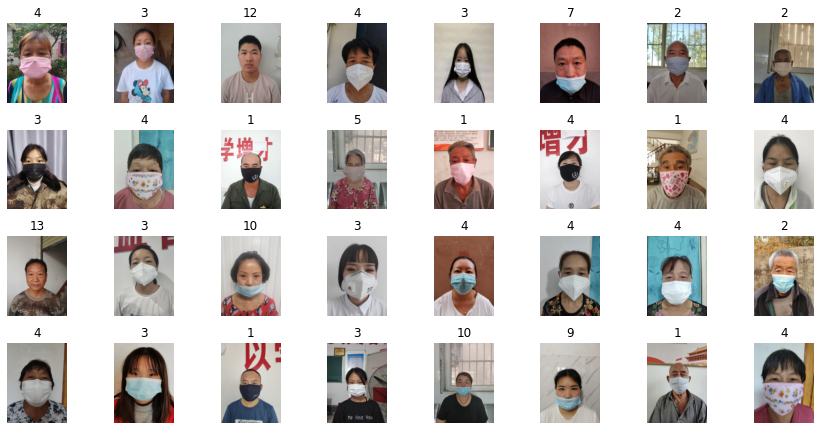

In [216]:
plt.figure(figsize=(12,12))
archor_images, positive_images, negative_images, labels = next(iter(dataloaders['train']))
archor_images, labels
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

for n, (archor_image, label) in enumerate(zip(archor_images, labels[0]), start=1):
    #plt.subplot(8,8, n)
    #imshow(archor_image)
    #plt.title("{}".format(label))
    #plt.axis('off')
    pass

for n, (positive_image, label) in enumerate(zip(positive_images, labels[1]), start=1):
    #plt.subplot(8, 8, n)
    #imshow(positive_image)
    #plt.title("{}".format(label))
    #plt.axis('off')
    pass

for n, (negative_image, label) in enumerate(zip(negative_images, labels[2]), start=1):
    plt.subplot(8, 8, n)
    imshow(negative_image)
    plt.title("{}".format(label))
    plt.axis('off')
    pass
plt.tight_layout()
plt.show()    

In [217]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes= 18)
'''model = torchvision.models.wide_resnet50_2(pretrained=True)
in_feat = model.fc.in_features
    

model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_feat, out_features=18, bias=True),
    torch.nn.Dropout(0.2)
)'''
# ... image preprocessing as in the classification example ...
#archor_image = archor_image.unsqueeze(dim = 0)
#archor_image = archor_image.unsqueeze(dim = 0) # torch.Size([1, 3, 224, 224])
'''positive_image = positive_image.unsqueeze(dim = 0)
negative_image = negative_image.unsqueeze(dim = 0) 
features = model.extract_features(archor_image)
print(features.shape)'''

Loaded pretrained weights for efficientnet-b1


'positive_image = positive_image.unsqueeze(dim = 0)\nnegative_image = negative_image.unsqueeze(dim = 0) \nfeatures = model.extract_features(archor_image)\nprint(features.shape)'

In [218]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [219]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.TripletMarginLoss(margin=1.0, p=2)

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.05)
lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [220]:
def acc_solve(pred, label):
    cnt = 0
    for i, j in zip(pred, label):
        if i == j:
           cnt += 1
    return torch.tensor(cnt)

In [221]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [222]:
ct = 0
epochs = 10
best_test_accuracy = 0.
best_test_loss = 0.
for epoch in tqdm(range(epochs), desc="Epochs"):
    for (name, module) in model.named_children():
        if name == 'features':
            for layer in module.children():
                if ct > 4:
                    for param in layer.parameters():
                        param.requires_grad = False
    ct += 1
    running_loss = []
    for phase in ["train", "valid"]:
        running_loss = 0.
        anchor_running_acc = 0.
        positive_running_acc = 0.
        negative_running_acc = 0.
        if phase == "train":
            model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "valid":
            model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        for step, (anchor_img, positive_img, negative_img, labels) in enumerate(tqdm(dataloaders['train'] , desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                anchor_out = model(anchor_img)
                _, anchor_preds = torch.max(anchor_out, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                positive_out = model(positive_img)
                _, positive_preds = torch.max(positive_out, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                negative_out = model(negative_img)
                _, negative_preds = torch.max(negative_out, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                
                
                loss = criterion(anchor_out, positive_out, negative_out)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
            running_loss += loss.cpu().detach().numpy() # 한 Batch에서의 loss 값 저장
            anchor_running_acc += acc_solve(anchor_preds, labels[0])
            positive_running_acc += acc_solve(positive_preds, labels[1]) # 한 Batch에서의 Accuracy 값 저장
            negative_running_acc += acc_solve(negative_preds, labels[2]) # 한 Batch에서의 Accuracy 값 저장
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        anchor_epoch_acc = anchor_running_acc / len(dataloaders[phase].dataset)
        positive_epoch_acc = positive_running_acc / len(dataloaders[phase].dataset)
        negative_epoch_acc = negative_running_acc / len(dataloaders[phase].dataset)
        epoch_acc = (anchor_epoch_acc + positive_epoch_acc + negative_epoch_acc) / 3
        if phase == "valid" and best_test_accuracy < epoch_acc:
            best_test_accuracy = epoch_acc
            torch.save(model.state_dict(), '/opt/ml/input/data/train' + 'model.pt')
        if phase == "valid" and best_test_loss < epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
        print("Epoch: {}/{} - Loss: {:.4f}, acc : {:.4f}".format(epoch+1, epochs, np.mean(running_loss), anchor_epoch_acc))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 - Loss: 353.3237, acc : 0.0337


Epochs:  10%|█         | 1/10 [05:19<47:51, 319.08s/it]

Epoch: 1/10 - Loss: 246.5207, acc : 0.1172


Epoch: 2/10 - Loss: 183.3522, acc : 0.0374


Epochs:  20%|██        | 2/10 [10:38<42:33, 319.23s/it]

Epoch: 2/10 - Loss: 153.2367, acc : 0.1794


Epoch: 3/10 - Loss: 114.5233, acc : 0.0706


Epochs:  30%|███       | 3/10 [15:56<37:11, 318.81s/it]

Epoch: 3/10 - Loss: 53.3742, acc : 0.0288


Epoch: 4/10 - Loss: 57.6216, acc : 0.0268


Epochs:  40%|████      | 4/10 [21:16<31:54, 319.08s/it]

Epoch: 4/10 - Loss: 40.2400, acc : 0.0228


Epoch: 5/10 - Loss: 46.5481, acc : 0.0076


Epochs:  50%|█████     | 5/10 [26:35<26:35, 319.10s/it]

Epoch: 5/10 - Loss: 44.8545, acc : 0.0016


Epoch: 6/10 - Loss: 40.0681, acc : 0.0033


Epochs:  60%|██████    | 6/10 [31:55<21:17, 319.36s/it]

Epoch: 6/10 - Loss: 33.1871, acc : 0.0013


Epoch: 7/10 - Loss: 34.2675, acc : 0.0055


Epochs:  70%|███████   | 7/10 [37:14<15:57, 319.32s/it]

Epoch: 7/10 - Loss: 44.7049, acc : 0.0108


Epoch: 8/10 - Loss: 30.8713, acc : 0.0062


Epochs:  80%|████████  | 8/10 [42:33<10:38, 319.25s/it]

Epoch: 8/10 - Loss: 36.9695, acc : 0.0124


Epochs:  80%|████████  | 8/10 [42:39<10:39, 319.96s/it]


KeyboardInterrupt: 

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
dataset_test = TestDataset(img_paths = image_paths, transform = transforms.Compose([
                                    transforms.Resize((128, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]))

loader = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)
print(len(loader))
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.load_state_dict(torch.load('/opt/ml/input/data/train' + 'model.pt'))  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
#optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197
test inference is done!
